In [1]:
from importlib import reload 
import lib.interpolate as functions
reload(functions) 
from lib.interpolate import *
from lib.plotting import *
import os
from more_itertools import pairwise
from collections import defaultdict

In [2]:
cwd = os.getcwd()
path = cwd+'/example/'

# Initialize interpolator

wav_ref, _ = np.loadtxt(cwd+'/database/lte050-4.5-0.0a+0.0.BT-NextGen.7.dat.txt', unpack=True)
interpolator = SpectrumInterpolator(wav_ref=wav_ref)

# Prepare inputs
targets = pd.read_csv('stars.csv') # List of objects to interpolate
target = targets.loc[targets['star'] == 'HAT-P-3 ']
spectra = pd.read_csv(path+'hat-p-3_data.csv')  # Your spectra data
interpolate_flags = pd.read_csv(path+'hat-p-3_interpolate.csv')

Initializing class...



In [3]:
target

,star,teff,logg,feh
4,HAT-P-3,5180,4.56,0.27


In [23]:
target['star'].item().strip().lower()

'hat-p-3'

In [4]:
interpolate_flags

,teff,logg,feh
0,True,True,True


In [5]:
spectra

,teff,logg,feh,alpha,path
0,5100,4.5,0.5,0,/database/lte051-4.5+0.5a+0.0.BT-NextGen.7.dat...
1,5100,4.5,0.0,0,/database/lte051-4.5-0.0a+0.0.BT-NextGen.7.dat...
2,5100,5.0,0.5,0,/database/lte051-5.0+0.5a+0.0.BT-NextGen.7.dat...
3,5100,5.0,0.0,0,/database/lte051-5.0-0.0a+0.0.BT-NextGen.7.dat...
4,5200,4.5,0.5,0,/database/lte052-4.5+0.5a+0.0.BT-NextGen.7.dat...
5,5200,4.5,0.0,0,/database/lte052-4.5-0.0a+0.0.BT-NextGen.7.dat...
6,5200,5.0,0.5,0,/database/lte052-5.0+0.5a+0.0.BT-NextGen.7.dat...
7,5200,5.0,0.0,0,/database/lte052-5.0-0.0a+0.0.BT-NextGen.7.dat...


In [8]:
params = {
        'teff': target['teff'].item(),
        'logg': target['logg'].item(),
        'feh': target['feh'].item()
        }

parameters = list(params.keys())

delta_params = {
        'teff': 100,  # [K]
        'logg': 0.5,  # [dex]
        'feh': 0.5    # [dex]
        }

In [6]:
def sort_df(df, param, interpolate_flags):

    params = list(interpolate_flags.columns)

    results = []
    
    grouped = df.groupby([p for p in params if p != param])
    
    for _, group in grouped:
        min_row = group.loc[group[param].idxmin()]
        max_row = group.loc[group[param].idxmax()]
        results.extend([min_row, max_row])
    
    return pd.DataFrame(results) if results else pd.DataFrame()

In [7]:
def load_and_interpolate_spectrum(row):
        """
        Load spectrum from file and interpolate to wavelength resolution of reference.
        """

        wav, spec = np.loadtxt(cwd + row['path'], unpack=True)
        return np.interp(wav_ref, wav, spec)

In [9]:
def combine_dicts(dict_list):

    combined = defaultdict(list)
    for d in dict_list:
        for key, value in d.items():
            combined[key].append(value)

    return pd.DataFrame(dict(combined))

In [10]:
def interp_param(df, param):

    interp_steps = [] # This will storage each dictionary with updated parameters and the corresponding interpolated flux

    for i in tqdm(range(0, len(df), 2), desc='Interpolating pairs for '+str(param)):
        row1 = df.iloc[i, :].to_dict()  # First row of the pair
        row2 = df.iloc[i + 1, :].to_dict() if i + 1 < len(df) else None  # Second row (if exists)
        
        if row2 is None:
            pass

        try:
            spec1 = load_and_interpolate_spectrum(row1) # This will work only for the first interpolated parameter
            spec2 = load_and_interpolate_spectrum(row2)

        except:
            spec1 = row1['flux'] # Then for the rest of the parameters this should work
            spec2 = row2['flux']

        factor = params[param] - row1[param] # Desidered value - minimum parameter value

        interp_flux = interpolator.interp_partial(
            spec1,
            spec2,
            factor,
            delta_params[param]
        )

        dic = {key: params[param] if key == param else row1[key] for key in parameters} # It can be row1 or row2 because the parameters' values are the same
        dic['flux'] = interp_flux

        interp_steps.append(dic)

    return interp_steps


# Automate process

In [17]:
steps = []

for param, condition in interpolate_flags.iteritems():

    if condition[0]: # Checks whether the current parameter needs to be interpolated

        print('Interpolating', param)

        if len(steps) == 0:
            source = spectra # Original dataframe retrieved from filtering the database
        else:
            source = steps[-1] # Gets latest dataframe after first interpolation loop

        df = sort_df(source, param, interpolate_flags) # Sorts dataframe 
        df = interp_param(df, param) # Interpolates current parameter
        df = combine_dicts(df) # Combine dictionaries to create a new dataframe with updated values after interpolation
        steps.append(df)
        print(df)
    else:
        pass

Interpolating teff


Interpolating pairs for teff: 100%|██████████| 4/4 [00:31<00:00,  7.82s/it]


   teff  logg  feh                                               flux
0  5180   4.5  0.0  [3.7089199999999995e-99, 3.7089199999999995e-9...
1  5180   4.5  0.5  [3.709878000000001e-99, 3.709878000000001e-99,...
2  5180   5.0  0.0  [1.175568e-98, 1.175568e-98, 1.175568e-98, 1.1...
3  5180   5.0  0.5  [1.175302e-98, 1.175302e-98, 1.175302e-98, 1.1...
Interpolating logg


Interpolating pairs for logg: 100%|██████████| 2/2 [00:00<00:00, 103.95it/s]


   teff  logg  feh                                               flux
0  5180  4.56  0.0  [4.674531199999993e-99, 4.674531199999993e-99,...
1  5180  4.56  0.5  [4.6750550399999945e-99, 4.6750550399999945e-9...
Interpolating feh


Interpolating pairs for feh: 100%|██████████| 1/1 [00:00<00:00, 89.34it/s]

   teff  logg   feh                                               flux
0  5180  4.56  0.27  [4.674814073599994e-99, 4.674814073599994e-99,...


In [18]:
steps[-1]

,teff,logg,feh,flux
0,5180,4.56,0.27,"[4.674814073599994e-99, 4.674814073599994e-99,..."


# Testing

In [7]:
test = sort_df(spectra, 'teff', interpolate_flags) 
test

,teff,logg,feh,alpha,path
1,5100,4.5,0.0,0,/database/lte051-4.5-0.0a+0.0.BT-NextGen.7.dat...
5,5200,4.5,0.0,0,/database/lte052-4.5-0.0a+0.0.BT-NextGen.7.dat...
0,5100,4.5,0.5,0,/database/lte051-4.5+0.5a+0.0.BT-NextGen.7.dat...
4,5200,4.5,0.5,0,/database/lte052-4.5+0.5a+0.0.BT-NextGen.7.dat...
3,5100,5.0,0.0,0,/database/lte051-5.0-0.0a+0.0.BT-NextGen.7.dat...
7,5200,5.0,0.0,0,/database/lte052-5.0-0.0a+0.0.BT-NextGen.7.dat...
2,5100,5.0,0.5,0,/database/lte051-5.0+0.5a+0.0.BT-NextGen.7.dat...
6,5200,5.0,0.5,0,/database/lte052-5.0+0.5a+0.0.BT-NextGen.7.dat...


In [38]:
interp_steps = interp_param(test, 'teff')

Interpolating pairs for teff:   0%|          | 0/4 [00:00<?, ?it/s]

Interpolating pairs for teff: 100%|██████████| 4/4 [00:32<00:00,  8.23s/it]


In [39]:
df = combine_dicts(interp_steps)
df

,teff,logg,feh,flux
0,5180,4.5,0.0,"[3.7089199999999995e-99, 3.7089199999999995e-9..."
1,5180,4.5,0.5,"[3.709878000000001e-99, 3.709878000000001e-99,..."
2,5180,5.0,0.0,"[1.175568e-98, 1.175568e-98, 1.175568e-98, 1.1..."
3,5180,5.0,0.5,"[1.175302e-98, 1.175302e-98, 1.175302e-98, 1.1..."


In [40]:
df = sort_df(df, 'logg', interpolate_flags)
df

,teff,logg,feh,flux
0,5180,4.5,0.0,"[3.7089199999999995e-99, 3.7089199999999995e-9..."
2,5180,5.0,0.0,"[1.175568e-98, 1.175568e-98, 1.175568e-98, 1.1..."
1,5180,4.5,0.5,"[3.709878000000001e-99, 3.709878000000001e-99,..."
3,5180,5.0,0.5,"[1.175302e-98, 1.175302e-98, 1.175302e-98, 1.1..."


In [41]:
interp_steps2 = interp_param(df, 'logg')

Interpolating pairs for logg: 100%|██████████| 2/2 [00:00<00:00, 70.58it/s]


In [42]:
df2 = combine_dicts(interp_steps2)
df2

,teff,logg,feh,flux
0,5180,4.56,0.0,"[4.674531199999993e-99, 4.674531199999993e-99,..."
1,5180,4.56,0.5,"[4.6750550399999945e-99, 4.6750550399999945e-9..."


In [43]:
df2 = sort_df(df2, 'feh', interpolate_flags)
df2

,teff,logg,feh,flux
0,5180,4.56,0.0,"[4.674531199999993e-99, 4.674531199999993e-99,..."
1,5180,4.56,0.5,"[4.6750550399999945e-99, 4.6750550399999945e-9..."


In [44]:
interp_steps3 = interp_param(df2, 'feh')
interp_steps3

Interpolating pairs for feh: 100%|██████████| 1/1 [00:00<00:00, 105.66it/s]


[{'teff': 5180,
  'logg': 4.56,
  'feh': 0.27,
  'flux': array([4.67481407e-99, 4.67481407e-99, 4.67481407e-99, ...,
         9.41954963e-06, 9.40028964e-06, 9.38110550e-06])}]

In [45]:
df3 = combine_dicts(interp_steps3)
df3

,teff,logg,feh,flux
0,5180,4.56,0.27,"[4.674814073599994e-99, 4.674814073599994e-99,..."


# Plot result

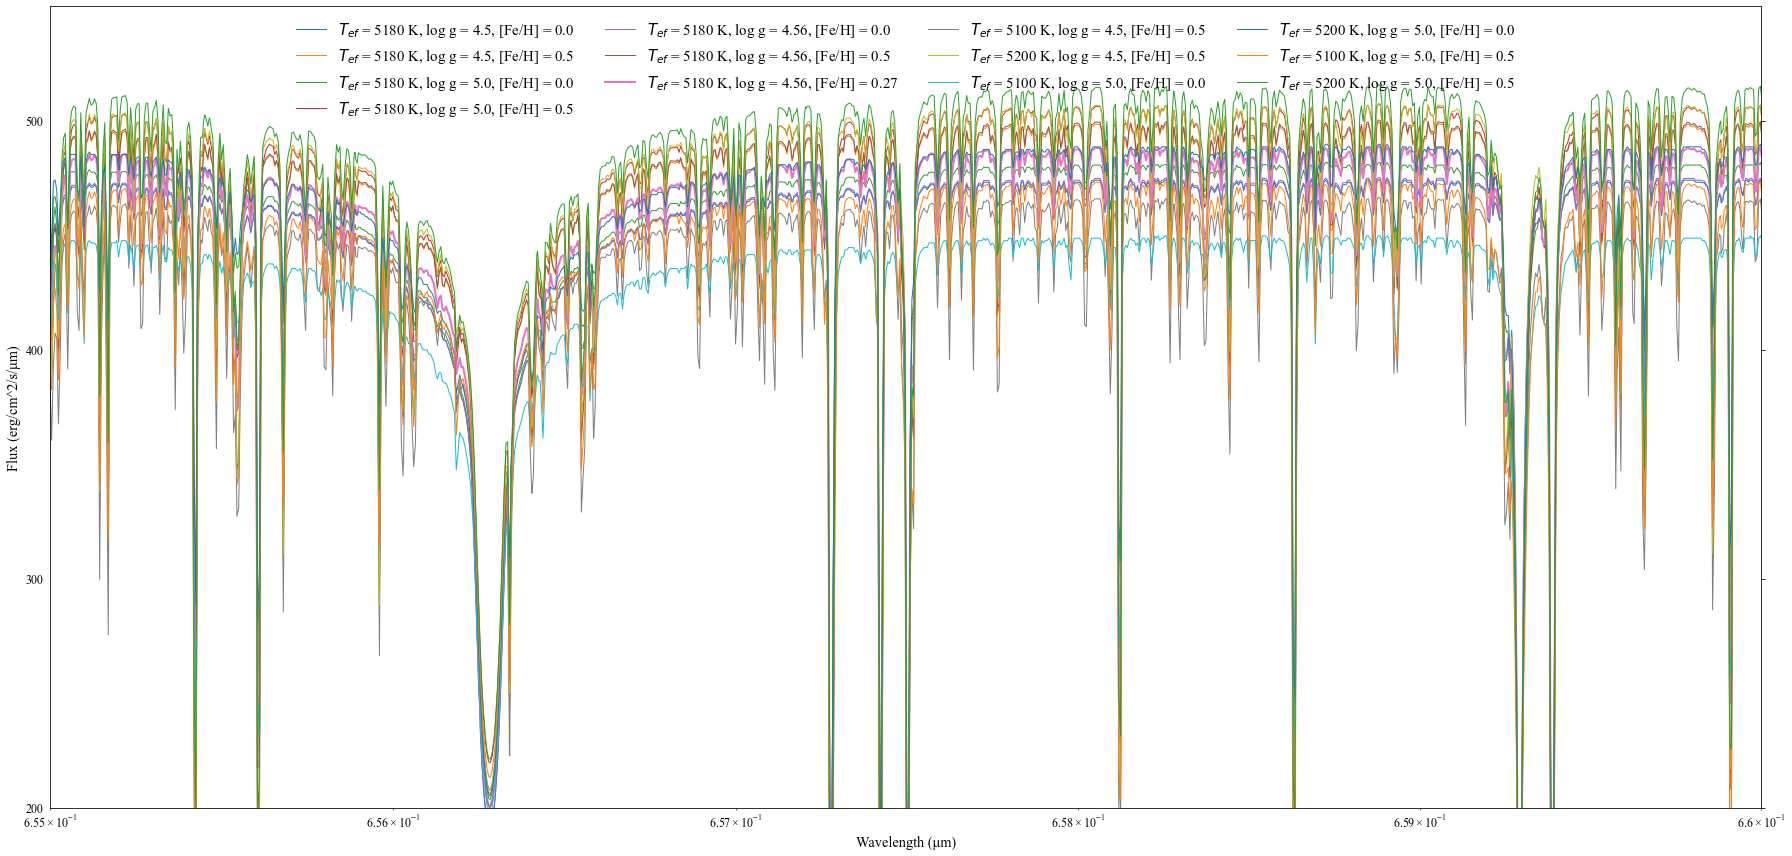

AttributeError: module 'matplotlib.pyplot' has no attribute 'closw'

In [80]:
steps = [interp_steps, interp_steps2, interp_steps3]

fig, ax = plt.subplots(figsize=(25,12), facecolor='white')

for step in steps:

    for df in step:

        if len(step) == 1:
            lw=2
        else:
            lw=1

        ax.plot(wav_ref/1e4,df['flux']/1e4, lw=lw, label = '$T_{ef}$ = '+str(int(df['teff']))+' K, log g = '+
                     str(df['logg'])+', [Fe/H] = '+str(df['feh']))

for i in range(0, len(test), 2):
    row = test.iloc[i, :].to_dict()
    row2 = test.iloc[i + 1, :].to_dict() if i + 1 < len(test) else None  # Second row (if exists)
        
    if row2 is None:
        pass

    flux = load_and_interpolate_spectrum(row)
    try:
        flux2 = load_and_interpolate_spectrum(row2)

    except:
        continue

    ax.plot(wav_ref/1e4,flux/1e4, lw=1, label = '$T_{ef}$ = '+str(int(row['teff']))+' K, log g = '+
                     str(row['logg'])+', [Fe/H] = '+str(row['feh']))
    ax.plot(wav_ref/1e4,flux2/1e4, lw=1, label = '$T_{ef}$ = '+str(int(row2['teff']))+' K, log g = '+
                     str(row2['logg'])+', [Fe/H] = '+str(row2['feh']))

ax.legend(fontsize = 15, loc='upper center', bbox_to_anchor=(0.5, 1.0),
               fancybox=False, ncol=4, frameon=False)
    
ax.set_xscale('log')

ax.set_xlim(0.655, 0.66)
ax.set_ylim(200, 550)
ax.locator_params(axis='y', nbins=5)
plt.tick_params(labelcolor='k', which='both', top=False,
            bottom=True, left=False, right=True, labelsize='large')

plt.xlabel("Wavelength (μm)",fontsize = 'x-large')
plt.ylabel("Flux (erg/cm^2/s/μm)",fontsize = 'x-large')

plt.tight_layout()
plt.show()
plt.close()